In [1]:
import os
import torch
from torch.utils.data import DataLoader
from dataset.data_preparation import download, split_dataset
from dataset.super_resolution_dataset import SuperResolutionDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(777)
transform = transforms.Compose([
        transforms.ToTensor()
    ])
download("./data", "airplanes")
root_dir = 'data/airplanes'
dataset = SuperResolutionDataset(root_dir=root_dir, transform=transform)
dataset_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
save_dir = 'data/preprocessed_dataset'
os.makedirs(save_dir, exist_ok=True)


Dataset airplanes already exists.


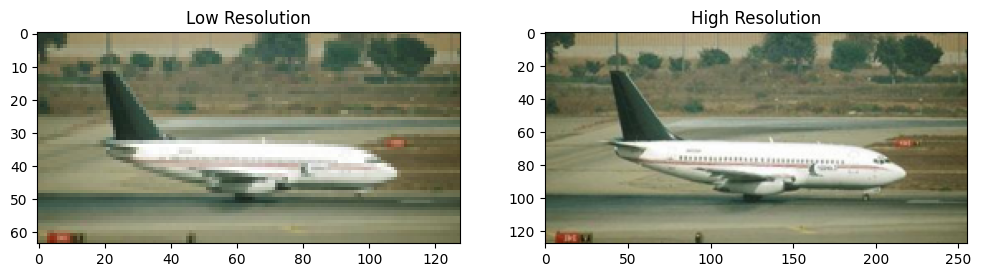

In [3]:
low_res, high_res = next(iter(dataset_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Tensors (channels, height, wight)
# matplot (height, wight, channels)
ax[0].imshow(low_res[0].permute(1, 2, 0))
ax[0].set_title("Low Resolution")

ax[1].imshow(high_res[0].permute(1, 2, 0))
ax[1].set_title("High Resolution")

plt.show()

In [4]:
sizes = {
    "train":0.5,
    "validation":0.3,
    "test":0.2
}
train, validation, test = split_dataset(dataset,sizes)

train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=True)

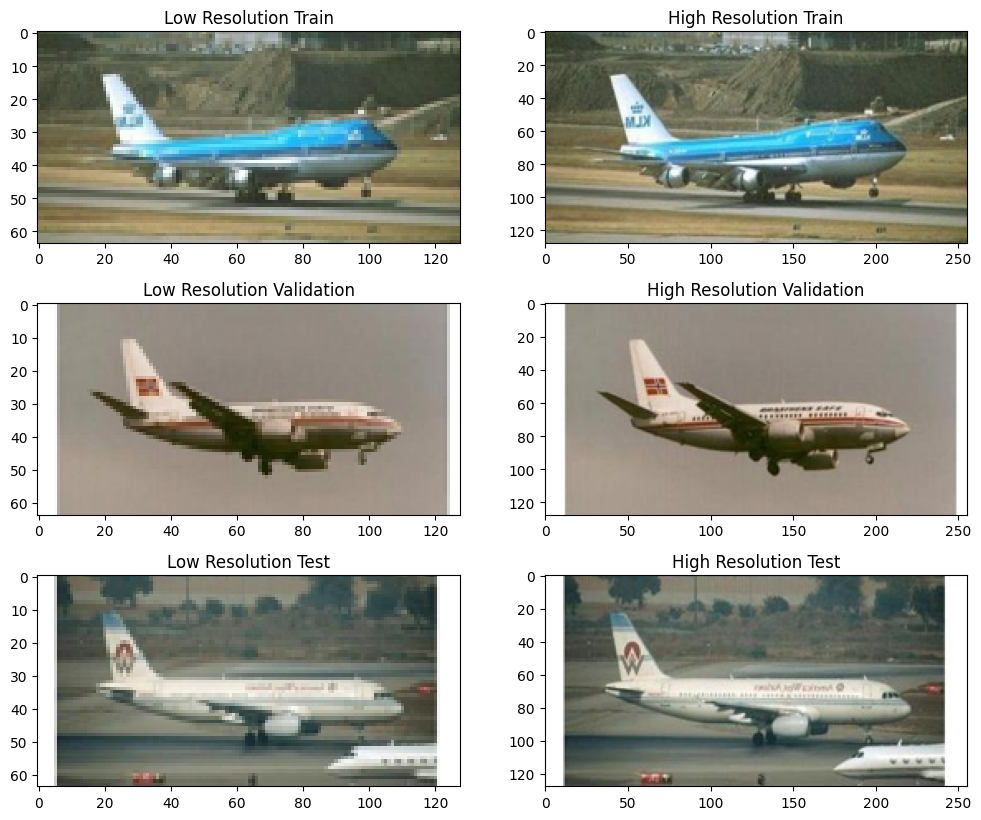

In [5]:
low_res_train, high_res_train = next(iter(train_dataloader))
low_res_validation, high_res_validation = next(iter(validation_dataloader))
low_res_test, high_res_test = next(iter(train_dataloader))
_ , ax = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle('Train-Validation-Test samples')

ax[0,0].imshow(low_res_train[0].permute(1, 2, 0))
ax[0,1].imshow(high_res_train[0].permute(1, 2, 0))
ax[1,0].imshow(low_res_validation[0].permute(1, 2, 0))
ax[1,1].imshow(high_res_validation[0].permute(1, 2, 0))
ax[2,0].imshow(low_res_test[0].permute(1, 2, 0))
ax[2,1].imshow(high_res_test[0].permute(1, 2, 0))

ax[0,0].set_title("Low Resolution Train")
ax[0,1].set_title("High Resolution Train")
ax[1,0].set_title("Low Resolution Validation")
ax[1,1].set_title("High Resolution Validation")
ax[2,0].set_title("Low Resolution Test")
ax[2,1].set_title("High Resolution Test")

plt.show()

In [6]:
from SRM.network import SuperResolution

In [7]:
SRN = SuperResolution(64,2)

print(SRN)

SuperResolution(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-2): 2 x ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): Upsample(
      (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shuffle): PixelShuffle(upscale_factor=2)
    )
    (4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [8]:
from torch import nn
import torch.optim as optim

loss_fn = nn.L1Loss()
optimiser = optim.Adam(SRN.parameters(), lr=pow(10, -4))

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
import os
from datetime import datetime
SRN = SRN.to(device)
SRN.train()
for epoch in range(5):
    epoch_loss = 0
    for x, y in train_dataloader:
        # Move the input and target images to the device (e.g., GPU)
        x = x.to(device)
        y = y.to(device)

        # Zero the gradients
        optimiser.zero_grad()

        # Forward pass
        output = SRN(x)

        # Calculate the loss
        loss = loss_fn(output, y)

        # Backward pass
        loss.backward()

        # Update the network parameters
        optimiser.step()


        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_dataloader)}')

Epoch 1, Loss: 0.21680833876132966
Epoch 2, Loss: 0.08621416151523591
Epoch 3, Loss: 0.0527349066734314
Epoch 4, Loss: 0.04293608501553536
Epoch 5, Loss: 0.03754397988319397
Model saved as super_resolution_model_20240803_113543.pth


In [12]:
os.makedirs("checkpoint", exist_ok=True)    
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"checkpoint/super_resolution_model_{timestamp}.pth"
torch.save(SRN.state_dict(), model_filename)
print(f'Model saved as {model_filename}')

Model saved as checkpoint/super_resolution_model_20240803_113730.pth


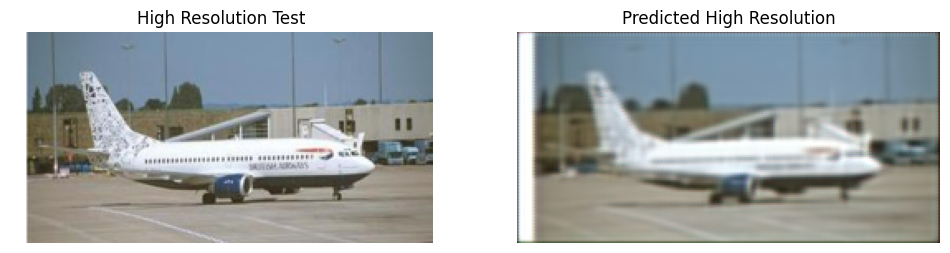

In [25]:
import numpy as np
from PIL import Image

prova = SuperResolution(64,2)
prova = prova.to(device)

checkpoint_path = "checkpoint/super_resolution_model_20240803_113730.pth"
prova.load_state_dict(torch.load(checkpoint_path))
prova.eval()

low_res_test, high_res_test = next(iter(test_dataloader))

low_res_test = low_res_test.to(device)

with torch.no_grad():
    predicted_high_res = SRN(low_res_test)
    
# Normalizza i valori dell'immagine prevista
predicted_image = predicted_high_res[0].permute(1, 2, 0).cpu().numpy()  # Converti in numpy
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()  # Clipping

# Salva l'immagine prevista
plt.imsave("predicted_high_resolution.png", predicted_image)  # Salva l'immagine

# Se vuoi usare PIL per salvare l'immagine
predicted_image = (predicted_image * 255).astype(np.uint8)  # Converti in uint8 per PIL
img = Image.fromarray(predicted_image)
img.save("predicted_high_resolution_pil.png")  # Salva l'immagine

# Visualizza le immagini
_, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 riga e 2 colonne
fig.suptitle('High Resolution and Predicted High Resolution Samples')

# Visualizza l'immagine ad alta risoluzione originale
ax[0].imshow(high_res_test[0].permute(1, 2, 0).cpu())
ax[0].set_title("High Resolution Test")
ax[0].axis('off')  # Nascondi gli assi

# Visualizza l'immagine ad alta risoluzione prevista
ax[1].imshow(predicted_image)
ax[1].set_title("Predicted High Resolution")
ax[1].axis('off')  # Nascondi gli assi

plt.show()